In [4]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

from utils import *
from tqdm.auto import tqdm
from scipy.stats import gaussian_kde
import numpy as np
import pickle
import os

from experiment import unpack_and_dequantize

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [5]:
# define results directories
cpt_dir = "../cpt/"
nocpt_dir = "../nocpt/"

# significant amplitude threshold
significant_amplitude_thresold = 10.0

# Heatmap for Dominant Amplitudes

### CPT

In [37]:
directory = "cpt"
with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["lambduh"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["rate"], P["w_delta_scale"], freqs[idx]["amplitudes"]))
    data.append(elem)

0it [00:00, ?it/s]

KeyError: 'lambduh'

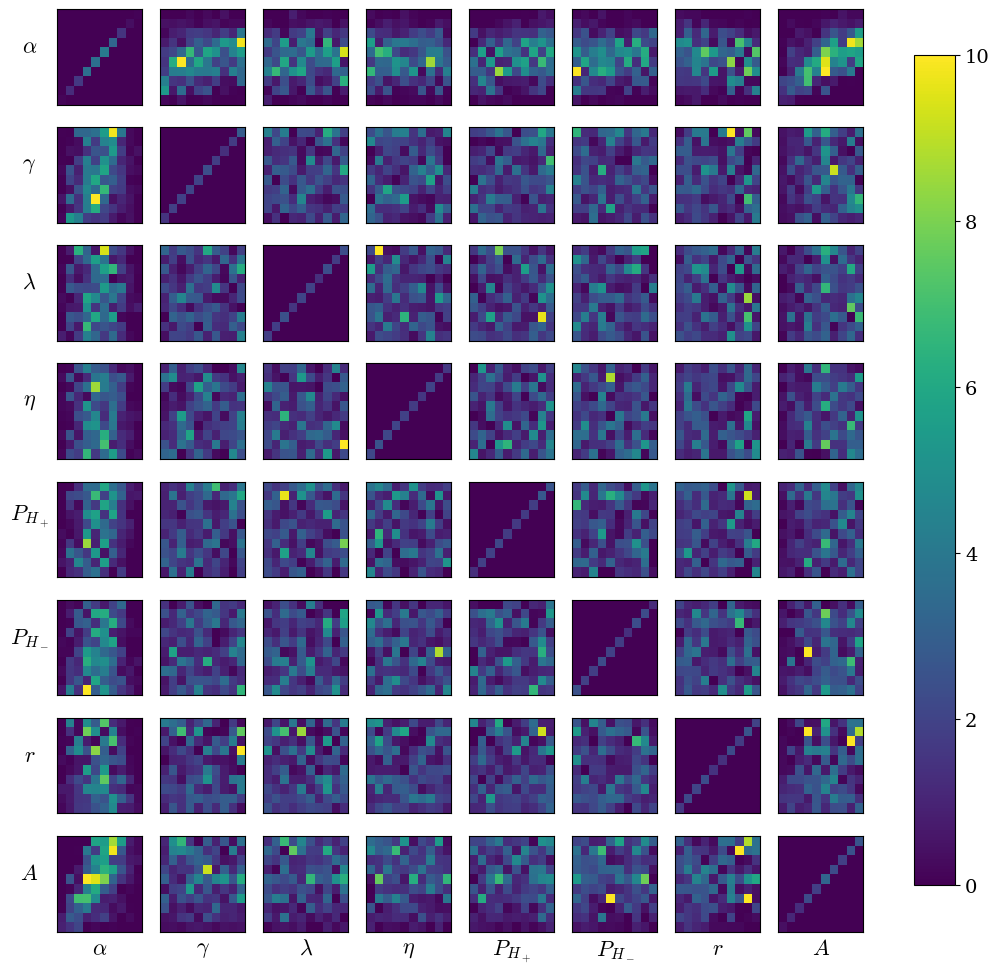

In [ ]:
param_names = [r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$r$", r"$A$"]
bounds = [[0.05,0.95], [0.5,0.8], [1.5,3], [0.65, 0.95], [0.05,0.95], [0.05,0.95], [1,5], [0.05,0.95]]
freq_lists = [d[-1] for d in data]

fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(11,10))

for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    amplitudes = [freq_lists[k] for k in idxs]
                    if amplitudes:
                        combined = np.concatenate(amplitudes) 
                        combined[np.isnan(combined)] = 0
                        heatmap[a, b] = combined.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=10)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

### NO CPT

In [ ]:
directory = "nocpt"
with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["rate"], P["w_delta_scale"], freqs[idx]["amplitudes"]))
    data.append(elem)

0it [00:00, ?it/s]

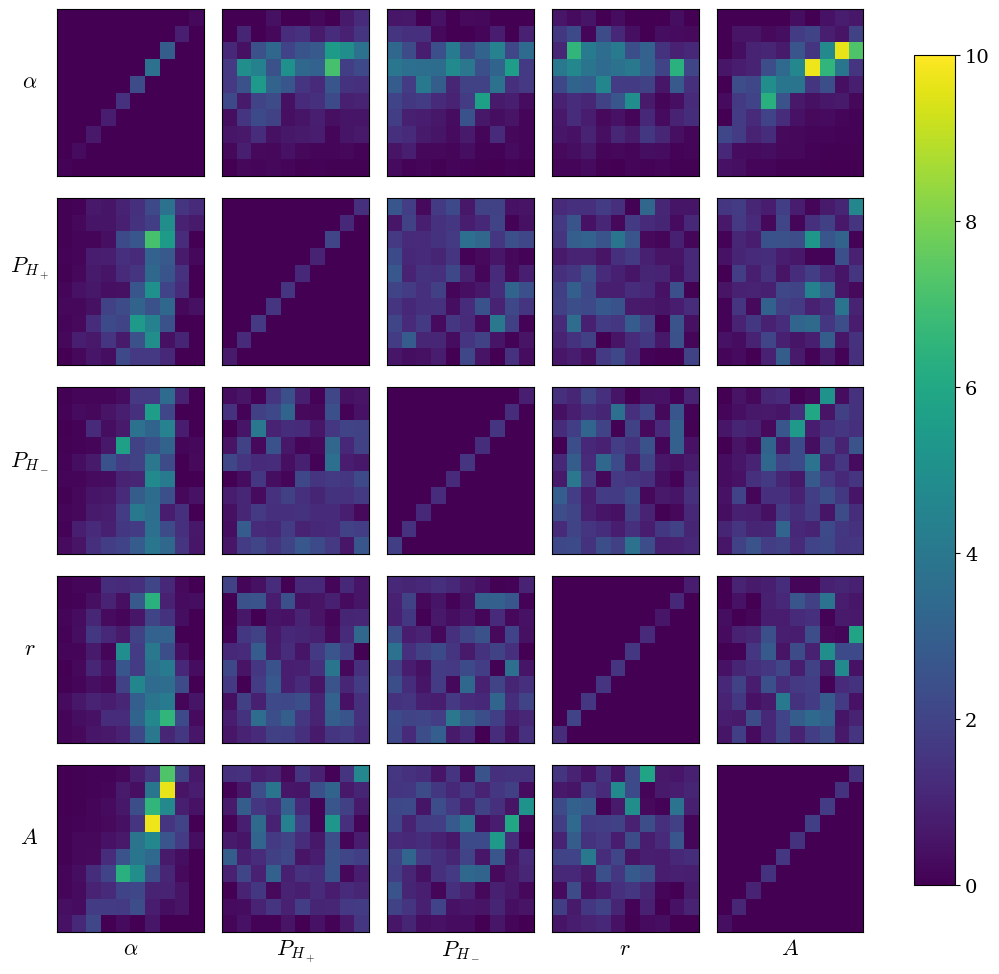

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(11,10))


freq_lists = [d[-1] for d in data]
param_names = [r"$\alpha$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$r$", r"$A$"]
bounds = [[0.05,0.95], [0.05,0.95], [0.05,0.95], [1,5], [0.05,0.95]]

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    amplitudes = [freq_lists[k] for k in idxs]
                    if amplitudes:
                        combined = np.concatenate(amplitudes) 
                        combined[np.isnan(combined)] = 0
                        heatmap[a, b] = combined.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=10)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# KDE of Dominant Amplitudes

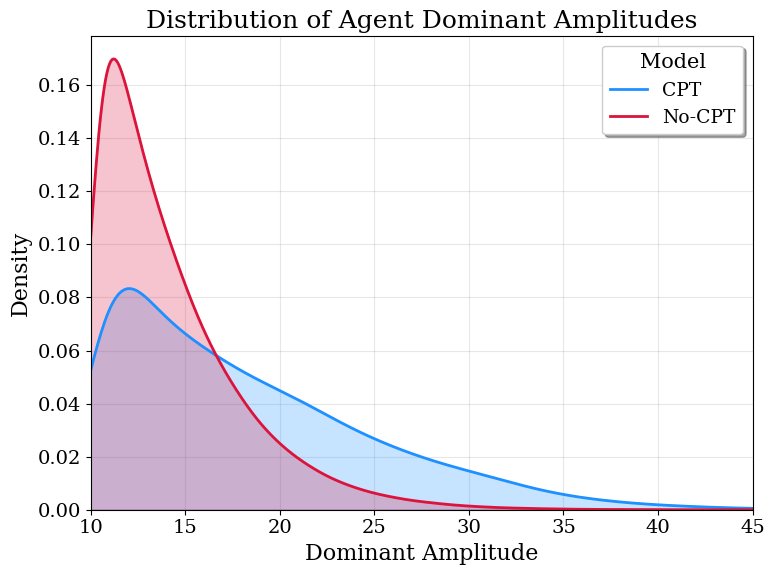

In [6]:
labels = ["CPT", "No-CPT"]
colors = ["dodgerblue", "crimson"]

for i, model in enumerate(["../cpt", "../nocpt"]):
    with open(model + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        amplitudes = pickle.load(f)

    sims = [s["amplitudes"] for s in amplitudes]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]
    sims = sims[sims >= significant_amplitude_thresold]

    # compute KDE
    kde = gaussian_kde(sims, bw_method=0.2)

    # grid for x-values
    x_vals = np.linspace(min(sims), max(sims), 500)
    y_vals = kde(x_vals)

    y_vals /= np.trapz(y_vals, x_vals)
    plt.plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=2)
    plt.fill_between(x_vals, y_vals, color=colors[i], alpha=0.25)

plt.xlabel("Dominant Amplitude")
plt.ylabel("Density")
plt.title(f"Distribution of Agent Dominant Amplitudes")
plt.legend(shadow=True, title="Model")

max_x_tick = 45
plt.xlim(significant_amplitude_thresold,max_x_tick)
plt.xticks(np.linspace(significant_amplitude_thresold, max_x_tick, 8))

plt.ylim(0,)
plt.grid()
plt.tight_layout()
plt.savefig("../figures/agent_amplitude_kde.pdf", bbox_inches="tight")
plt.show()

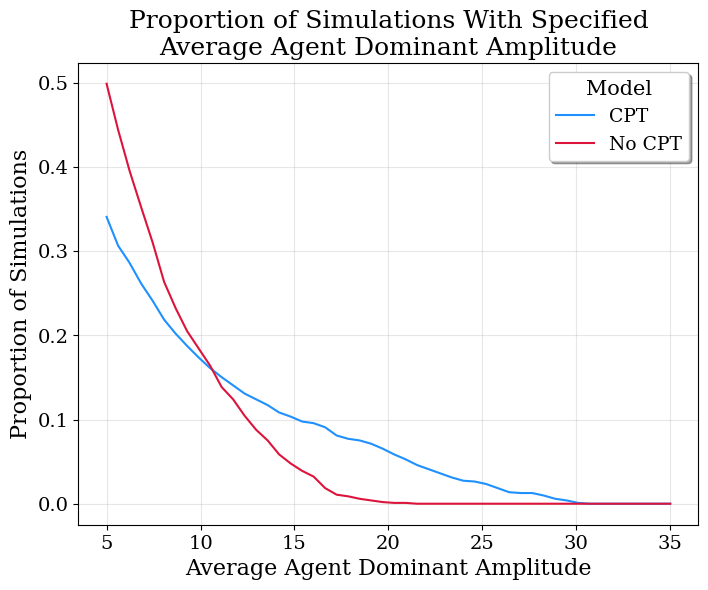

In [7]:
cutoffs = np.linspace(5, 35, 50)
labels = ["CPT", "No CPT"]
colors = ["dodgerblue", "crimson"]
for i, model in enumerate(["cpt", "nocpt"]):
    with open("../"+model + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        amplitudes = pickle.load(f)
    count = []
    sims = [s["amplitudes"] for s in amplitudes]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]
    for mean_dominant_amplitude in cutoffs:
        subset = [x for x in amplitudes if np.mean(x["amplitudes"]) > mean_dominant_amplitude]
        count.append(len(subset)/1024)
    plt.plot(cutoffs, count, label=labels[i], color=colors[i])

plt.legend(shadow=True, title="Model")
plt.grid()
plt.title("Proportion of Simulations With Specified\nAverage Agent Dominant Amplitude")
plt.xlabel("Average Agent Dominant Amplitude")
plt.ylabel("Proportion of Simulations")
plt.show()

# Heatmaps for Dominant Frequencies

### CPT

In [ ]:
directory = "cpt"

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["omega"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], freqs[idx]))
    data.append(elem)

FileNotFoundError: [Errno 2] No such file or directory: 'cpt_dominant_frequencies.pickle'

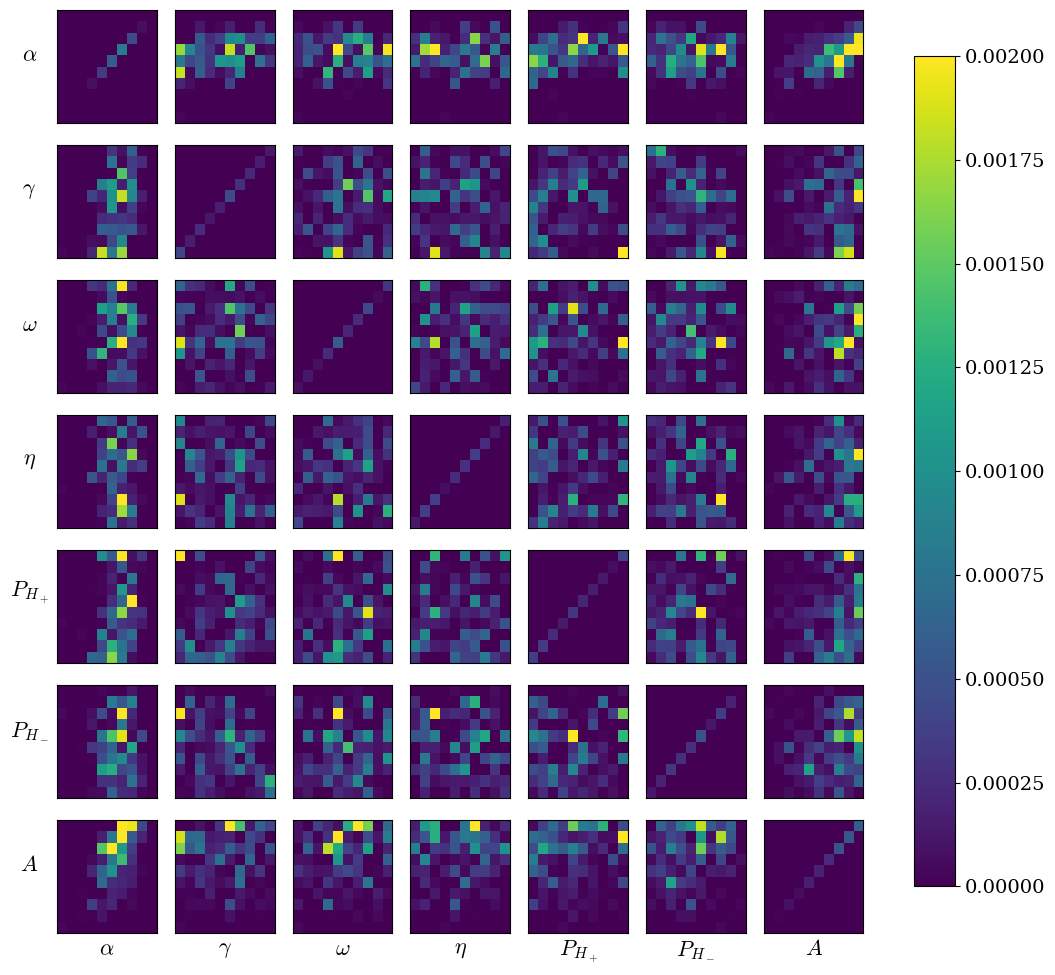

In [ ]:
fig, axs = plt.subplots(7, 7, figsize=(11,10))

param_names = [r"$\alpha$", r"$\gamma$", r"$\omega$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0.4,0.8], [1,4], [0.5, 1], [0,1], [0,1], [0,1]]
freq_lists = [d[-1] for d in data]

for i in range(7):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(7):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    freq_lists_min_agents = [freq_lists[k] for k in idxs]
                    if freq_lists_min_agents:
                        combined_freqs = np.concatenate(freq_lists_min_agents) 
                        combined_freqs[np.isnan(combined_freqs)] = 0
                        heatmap[a, b] = combined_freqs.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=0.002)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == 6:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

### NO CPT

In [ ]:
directory = "nocpt"

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], freqs[idx]))
    data.append(elem)

0it [00:00, ?it/s]

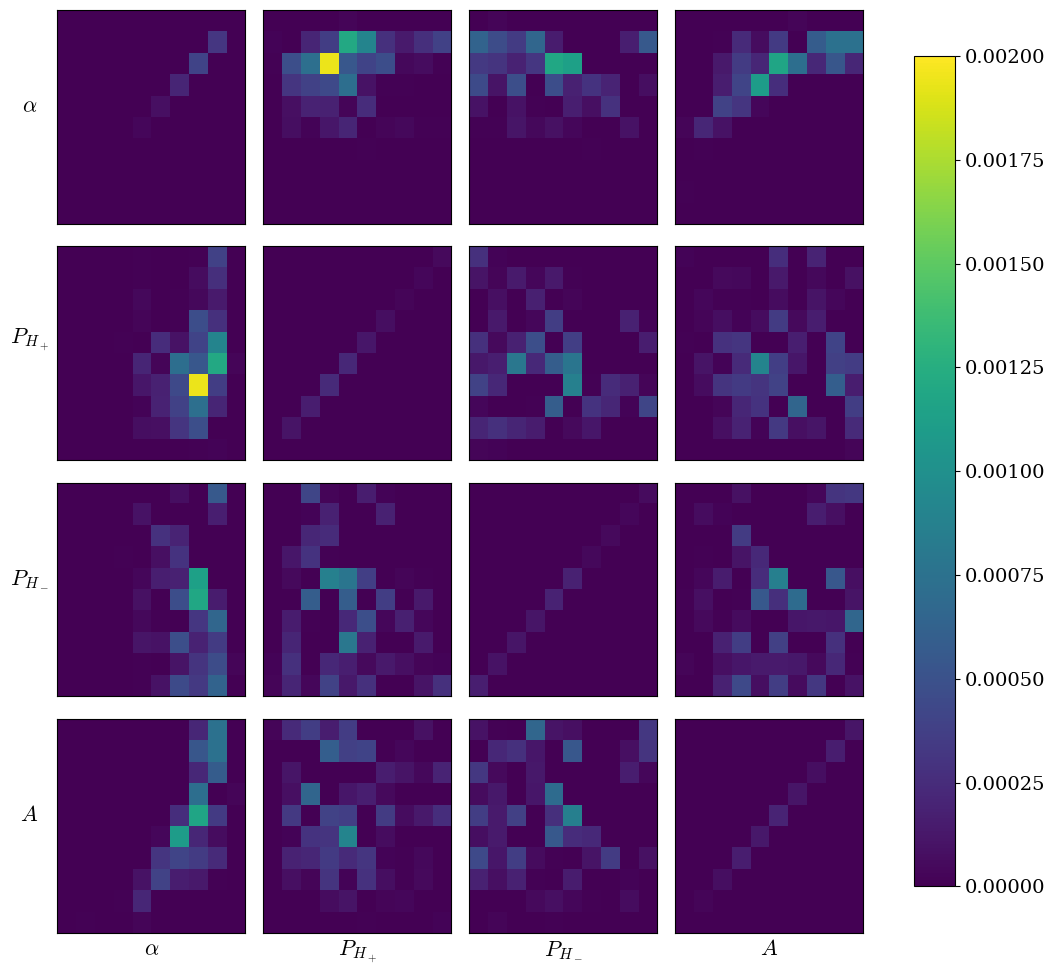

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(11,10))

param_names = [r"$\alpha$", r"$P_{H_+}$", r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0,1], [0,1], [0,1]]
freq_lists = [d[-1] for d in data]

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    freq_lists_min_agents = [freq_lists[k] for k in idxs]
                    if freq_lists_min_agents:
                        combined_freqs = np.concatenate(freq_lists_min_agents) 
                        combined_freqs[np.isnan(combined_freqs)] = 0
                        heatmap[a, b] = combined_freqs.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=0.002)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# Heatmaps for Oscillation Location

### CPT

In [ ]:
directory = "cpt"
cutoff = 1000

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

oscillating_bool = [int(len(np.where(~np.isnan(s))[0]) >= cutoff) for s in freqs]

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["omega"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], oscillating_bool[idx]))
    data.append(elem)

0it [00:00, ?it/s]

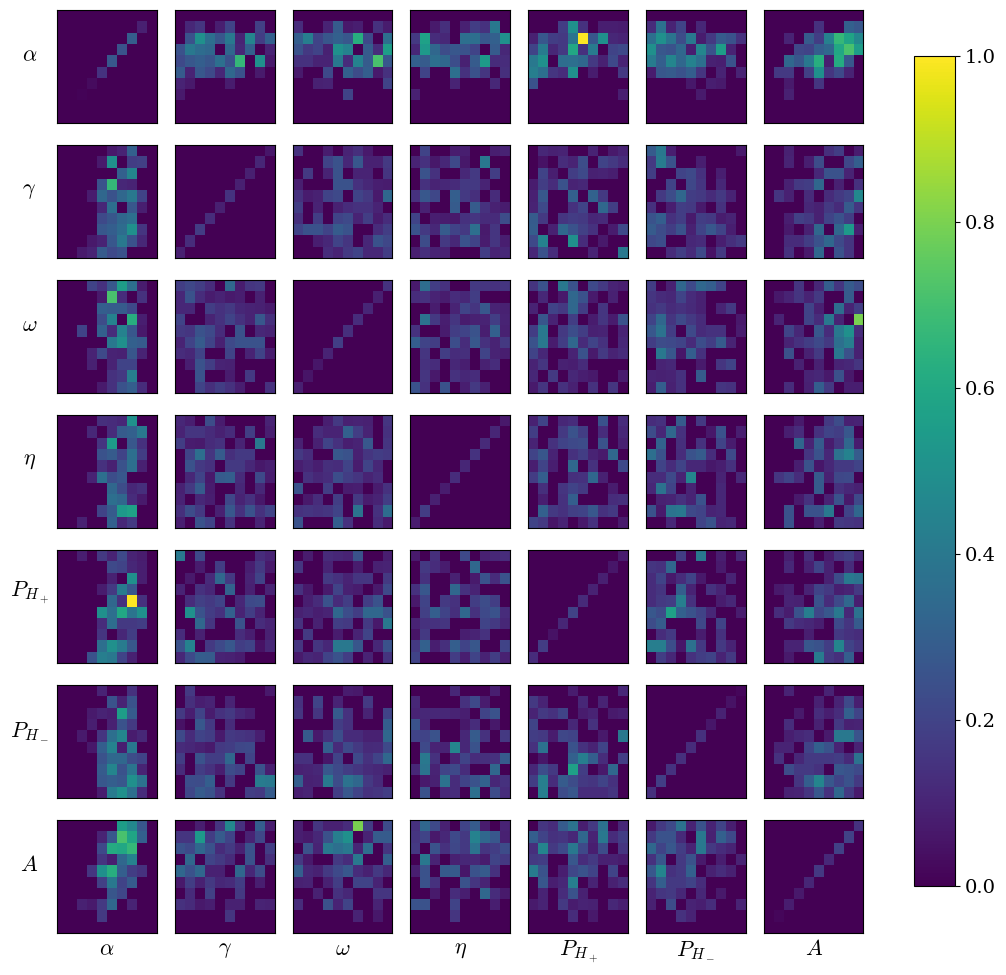

In [ ]:
fig, axs = plt.subplots(7, 7, figsize=(11,10))

param_names = [r"$\alpha$", r"$\gamma$", r"$\omega$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0.4,0.8], [1,4], [0.5, 1], [0,1], [0,1], [0,1]]
freq_lists = np.array([d[-1] for d in data])

for i in range(7):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(7):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]
                
                # Concatenate all lists of freqs in this bin
                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(freq_lists[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0.0, vmax=1.0)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == 6:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

### NO CPT

In [ ]:
directory = "nocpt"
cutoff = 1000

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

oscillating_bool = [int(len(np.where(~np.isnan(s))[0]) >= cutoff) for s in freqs]

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], oscillating_bool[idx]))
    data.append(elem)

0it [00:00, ?it/s]

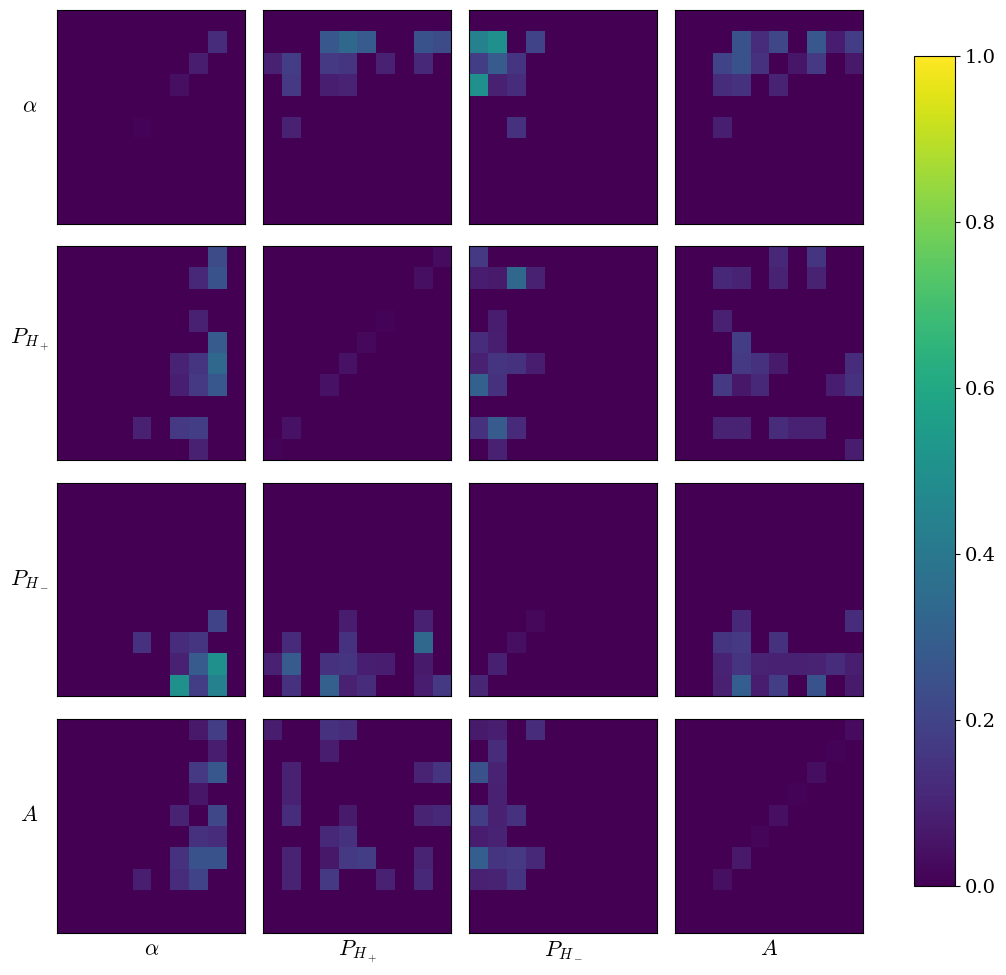

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(11,10))

param_names = [r"$\alpha$", r"$P_{H_+}$", r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0,1], [0,1], [0,1]]
freq_lists = np.array([d[-1] for d in data])

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                # Concatenate all lists of freqs in this bin
                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(freq_lists[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0.0, vmax=1.0)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# KDE of Dominant Freqs

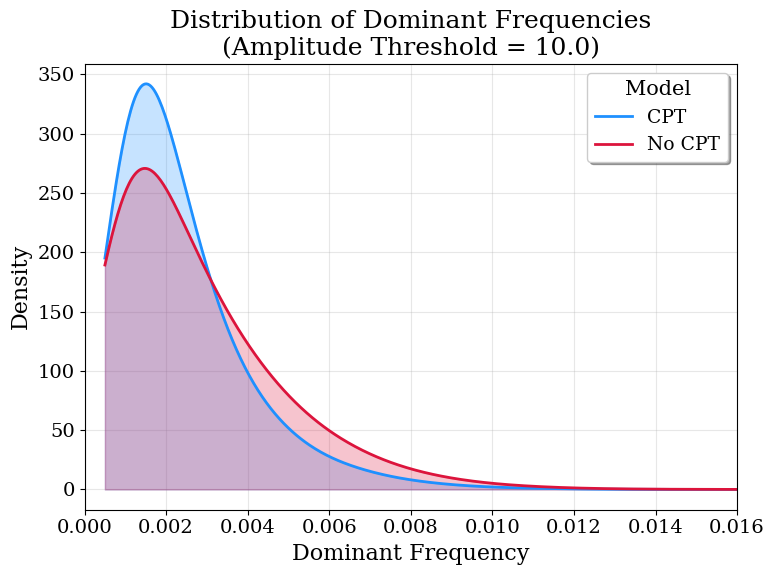

In [8]:
labels = ["CPT", "No CPT"]
colors = ["dodgerblue", "crimson"]

for i, directory in enumerate(["../cpt", "../nocpt"]):
    with open(directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        data = pickle.load(f)

    sims = [s["frequencies"] for s in data if np.mean(s["amplitudes"]) >= significant_amplitude_thresold]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]

    # compute KDE
    kde = gaussian_kde(sims, bw_method=0.4)

    # grid for x-values
    x_vals = np.linspace(min(sims), max(sims), 500)
    y_vals = kde(x_vals)

    # normalize so area = 1 (proportion density)
    y_vals /= np.trapz(y_vals, x_vals)
    plt.plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=2)
    plt.fill_between(x_vals, y_vals, color=colors[i], alpha=0.25)

plt.xlabel("Dominant Frequency")
plt.ylabel("Density")
plt.title(f"Distribution of Dominant Frequencies\n(Amplitude Threshold = {significant_amplitude_thresold})")
plt.legend(shadow=True, title="Model")
plt.grid()
plt.xlim(0,0.016)
plt.tight_layout()
plt.show()

# Radar Plots for Param Values

In [9]:
def load_data(directory):
    with open(f"../{directory}_dominant_frequencies_amplitudes.pickle", "rb") as f:
        freqs = pickle.load(f)
    y = np.array([np.mean(f["amplitudes"])for f in freqs])

    parameters = []
    for f_name in tqdm(os.listdir(f"../{directory}")):
        if f_name.endswith('.pickle'):
            with open(os.path.join(f"../{directory}", f_name), "rb") as f:
                P = pickle.load(f)["params"]
            # Different parameter sets for CPT vs No CPT
            if directory == "cpt":
                elem = (P["alpha"], P["gamma"], P["lambda"], P["rate"], P["A"], P["shock_size"])
            else:
                elem = (P["alpha"], P["rate"], P["A"], P["shock_size"])
            parameters.append(elem)
    return np.array(parameters), y

# Load data
cpt_P, cpt_y = load_data("cpt")
nocpt_P, nocpt_y = load_data("nocpt")

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [10]:
def prepare_radar_data(params, y, threshold):
    """Compute normalized average values and radar angles for plotting."""

    # Min-max normalization per dataset
    baseline = params[y<threshold]
    avg_baseline = np.mean(baseline, axis=0)
    min_vals_baseline = np.min(baseline, axis=0)
    max_vals_baseline = np.max(baseline, axis=0)
    normalized_avg_baseline = (avg_baseline - min_vals_baseline) / (max_vals_baseline - min_vals_baseline)

    significant = params[y>=threshold]
    avg_significant = np.mean(significant, axis=0)
    min_vals_significant = np.min(baseline, axis=0)
    max_vals_significant = np.max(baseline, axis=0)
    normalized_avg_significant = (avg_significant - min_vals_significant) / (max_vals_significant - min_vals_significant)

    # Compute angles for radar plot
    num_vars = params.shape[1]
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Close the radar plot
    normalized_avg_baseline = np.concatenate((normalized_avg_baseline, [normalized_avg_baseline[0]]))
    normalized_avg_significant = np.concatenate((normalized_avg_significant, [normalized_avg_significant[0]]))
    angles += angles[:1]

    return normalized_avg_baseline, normalized_avg_significant, angles

# Prepare radar data
cpt_baseline, cpt_significant, cpt_angles = prepare_radar_data(cpt_P, cpt_y, threshold=significant_amplitude_thresold)
nocpt_baseline, nocpt_significant, nocpt_angles = prepare_radar_data(nocpt_P, nocpt_y, threshold=significant_amplitude_thresold)

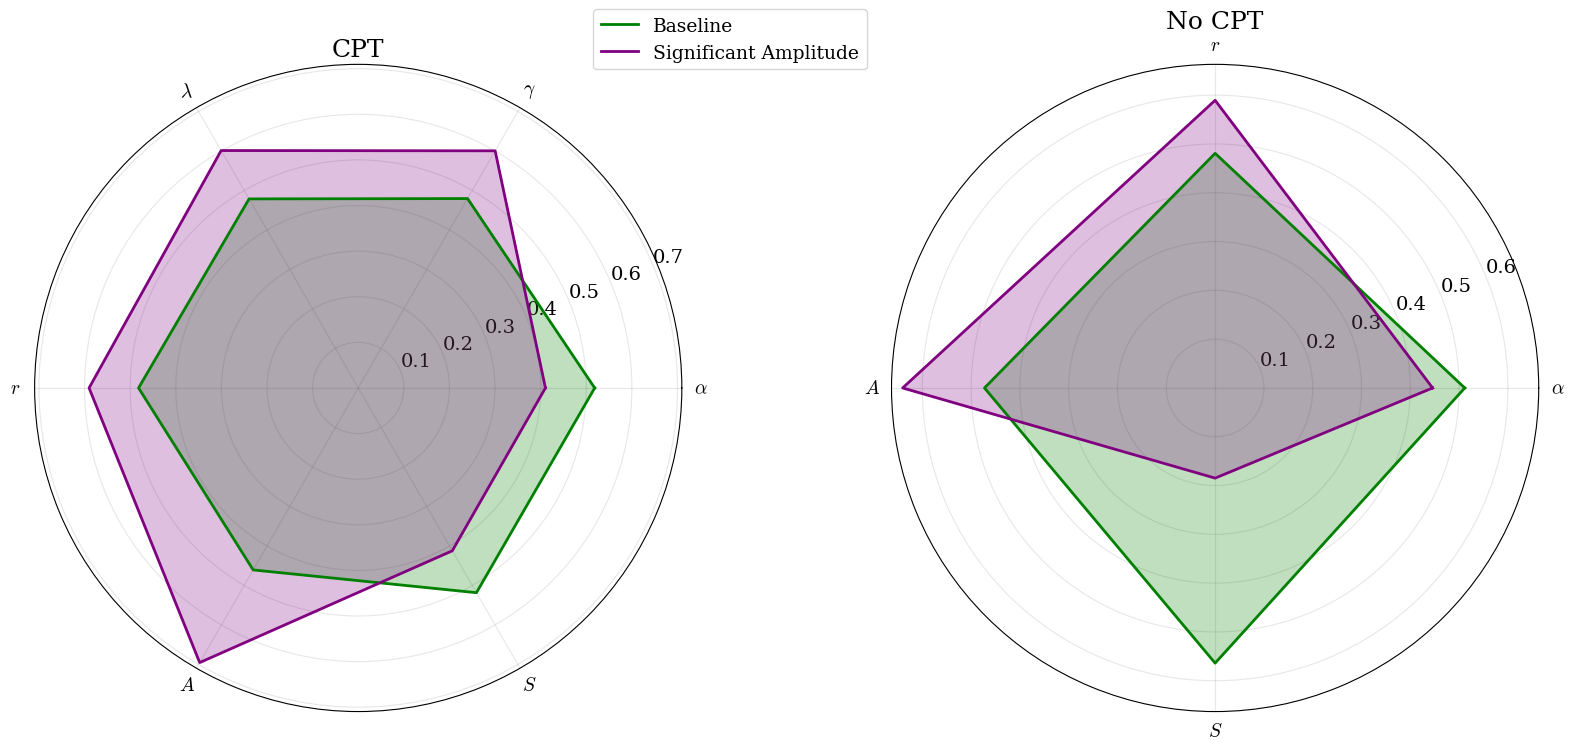

In [17]:
def plot_radar_chart(ax, angles, data_baseline, data_significant, labels, title, legend=True):
    """Helper function to plot a single radar chart."""
    ax.plot(angles, data_baseline, color="green", linewidth=2, linestyle='solid', label='Baseline')
    ax.fill(angles, data_baseline, color="green", alpha=0.25)
    ax.plot(angles, data_significant, color="purple", linewidth=2, linestyle='solid', label='Significant Amplitude')
    ax.fill(angles, data_significant, color="purple", alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title)
    if legend:
        ax.legend(bbox_to_anchor=(1.3, 1.1))

# Plot side-by-side radar charts
fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(polar=True))

cpt_labels = [r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$r$", r"$A$", r"$S$"]
plot_radar_chart(axs[0], cpt_angles, cpt_baseline, cpt_significant, cpt_labels, "CPT")

nocpt_labels = [r"$\alpha$", r"$r$", r"$A$", r"$S$"]
plot_radar_chart(axs[1], nocpt_angles, nocpt_baseline, nocpt_significant, nocpt_labels, "No CPT", legend=False)

plt.tight_layout()
plt.savefig("../figures/amplitude_radars.pdf", bbox_inches="tight")
plt.show()

# Large Mean Amplitude Simulations

  0%|          | 0/1024 [00:00<?, ?it/s]

{'N': 200, 'alpha': np.float64(0.3565838524565519), 'gamma': np.float64(0.7789071211831136), 'lambda': np.float64(2.810990889838255), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.939072906567533), 'A': np.float64(0.35968243061839494), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.9666947882787198)}


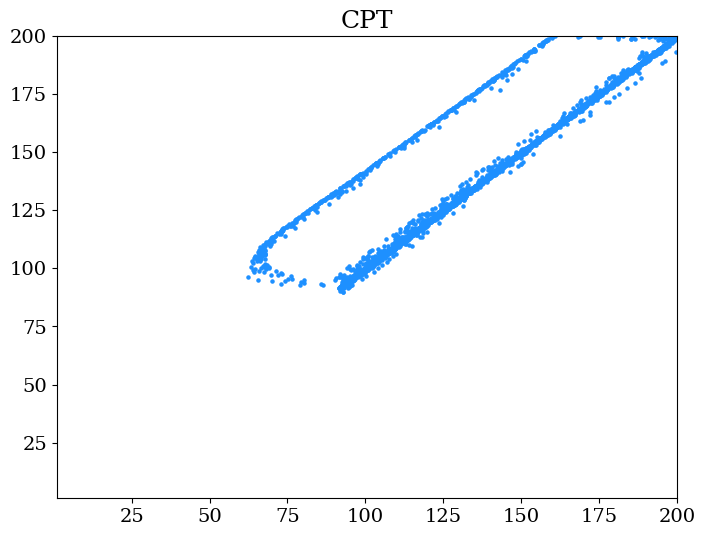

{'N': 200, 'alpha': np.float64(0.3565838524565519), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.939072906567533), 'A': np.float64(0.35968243061839494), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.9666947882787198)}


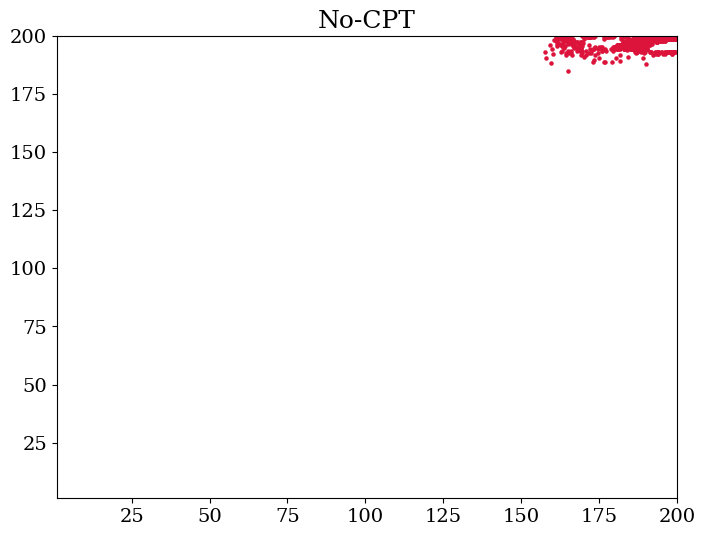

{'N': 200, 'alpha': np.float64(0.6154790399496587), 'gamma': np.float64(0.7322965429683415), 'lambda': np.float64(1.8167771636552503), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.819287263609676), 'A': np.float64(0.8366766290669136), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.8757106531518538)}


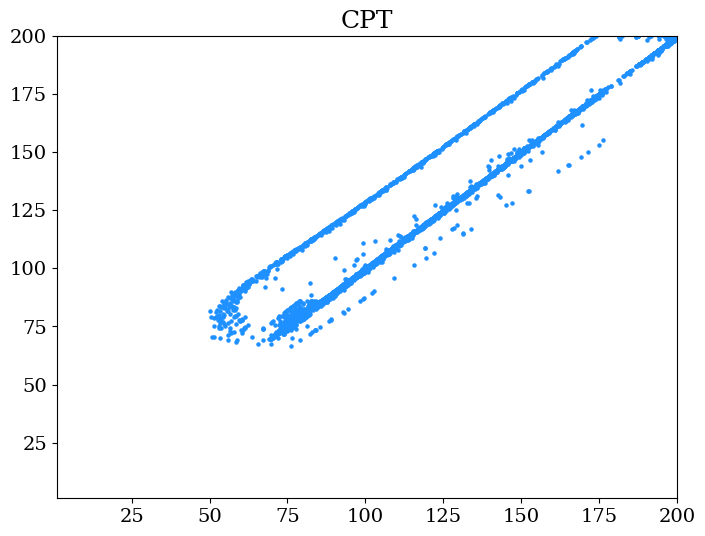

{'N': 200, 'alpha': np.float64(0.6154790399496587), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.819287263609676), 'A': np.float64(0.8366766290669136), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.8757106531518538)}


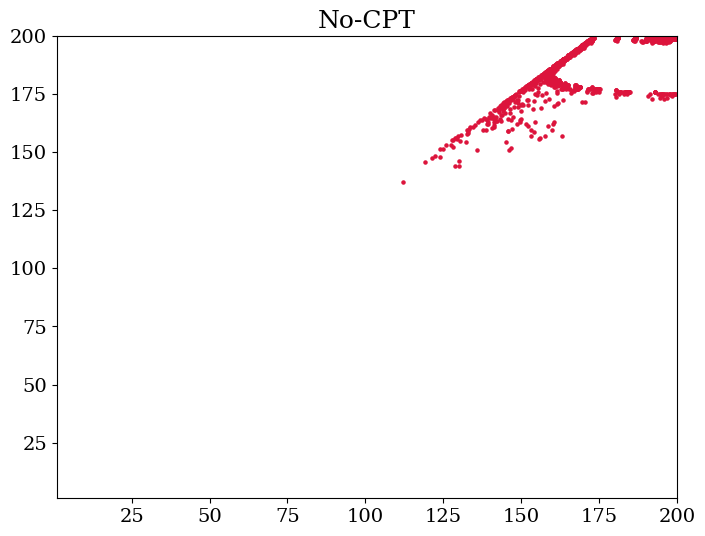

{'N': 200, 'alpha': np.float64(0.5877590404125651), 'gamma': np.float64(0.6987481358866556), 'lambda': np.float64(2.312023709811924), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.903009392933258), 'A': np.float64(0.7733183537531311), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.8806972193678264)}


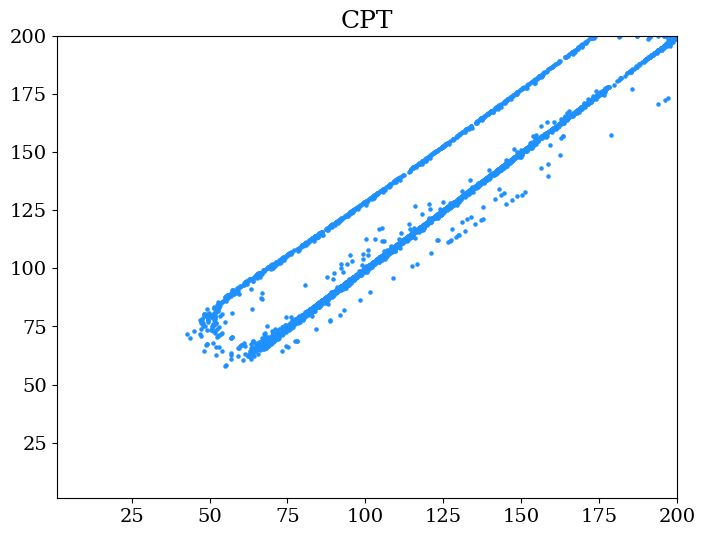

{'N': 200, 'alpha': np.float64(0.5877590404125651), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.903009392933258), 'A': np.float64(0.7733183537531311), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.8806972193678264)}


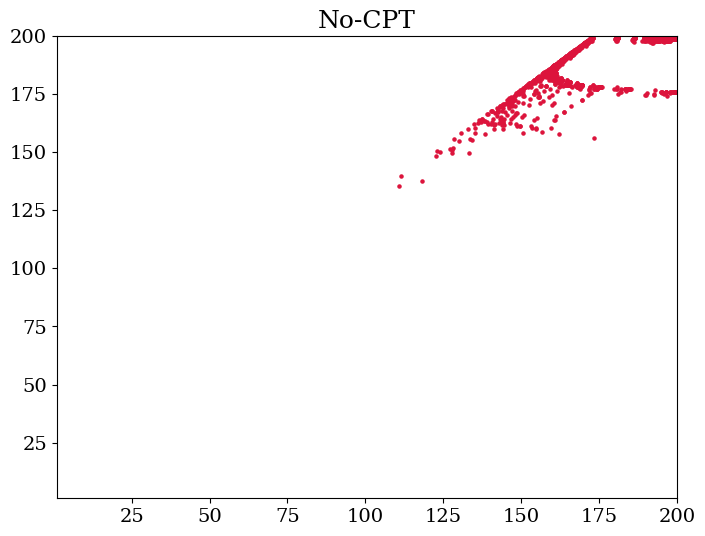

{'N': 200, 'alpha': np.float64(0.5410175744463579), 'gamma': np.float64(0.6614027119267921), 'lambda': np.float64(2.721116186319344), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.026637866422786), 'A': np.float64(0.6482256753647139), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.8704235918890971)}


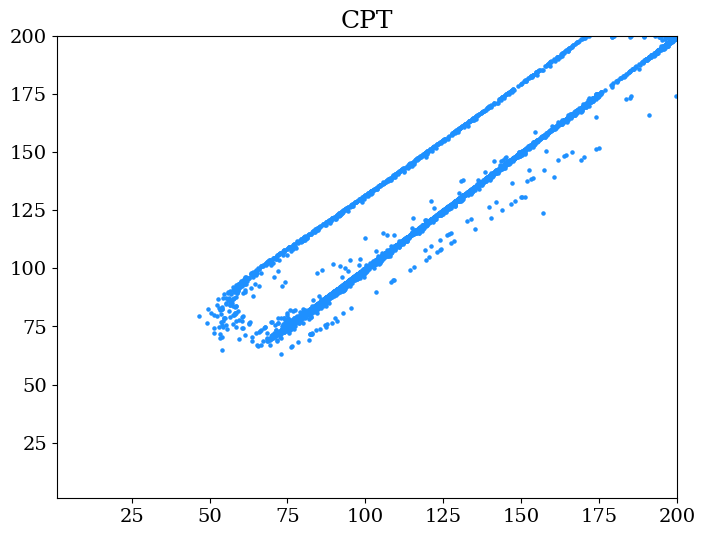

{'N': 200, 'alpha': np.float64(0.5410175744463579), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.026637866422786), 'A': np.float64(0.6482256753647139), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.8704235918890971)}


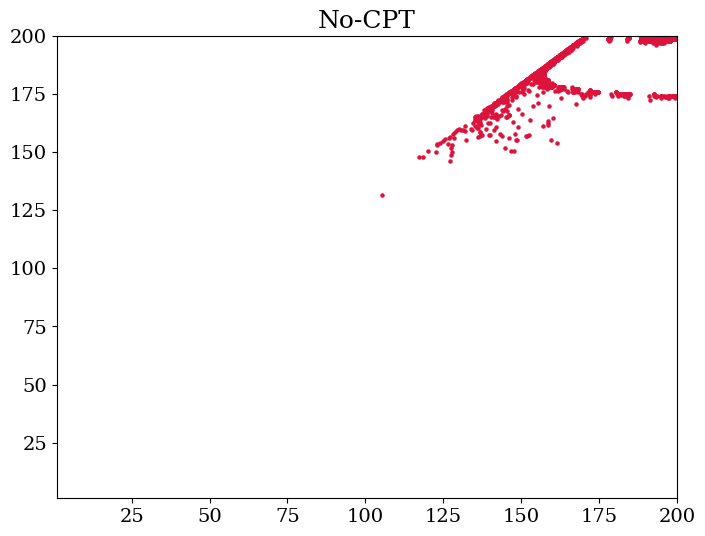

{'N': 200, 'alpha': np.float64(0.6199416981194898), 'gamma': np.float64(0.7512722292340035), 'lambda': np.float64(2.5450725499540754), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(3.760713329782443), 'A': np.float64(0.8325604478847142), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.9992772336864844)}


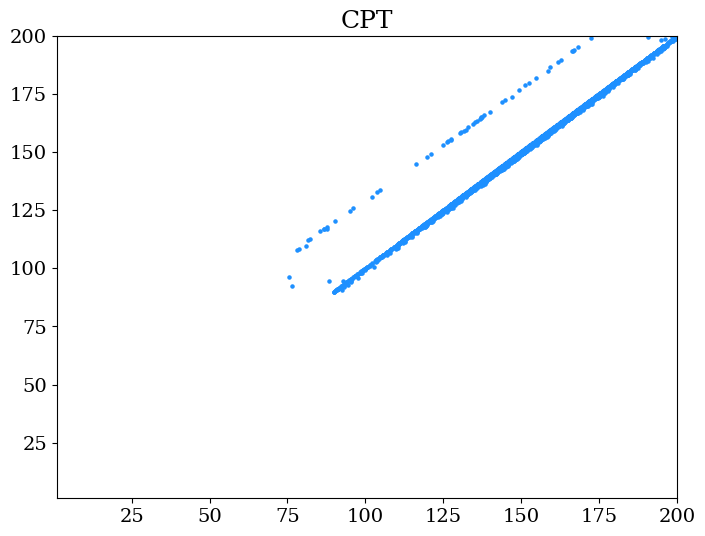

{'N': 200, 'alpha': np.float64(0.6199416981194898), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(3.760713329782443), 'A': np.float64(0.8325604478847142), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.9992772336864844)}


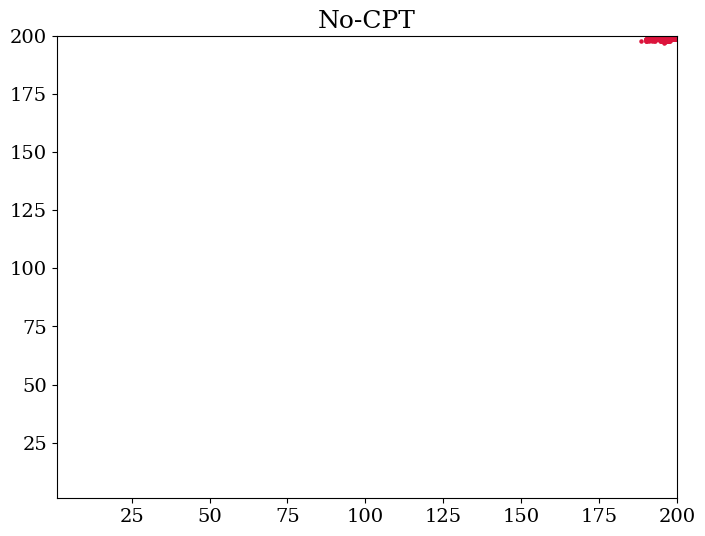

{'N': 200, 'alpha': np.float64(0.6368612839054785), 'gamma': np.float64(0.7620889228752585), 'lambda': np.float64(2.6071955350954745), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.971088209611549), 'A': np.float64(0.9259773695112138), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.7557021408552176)}


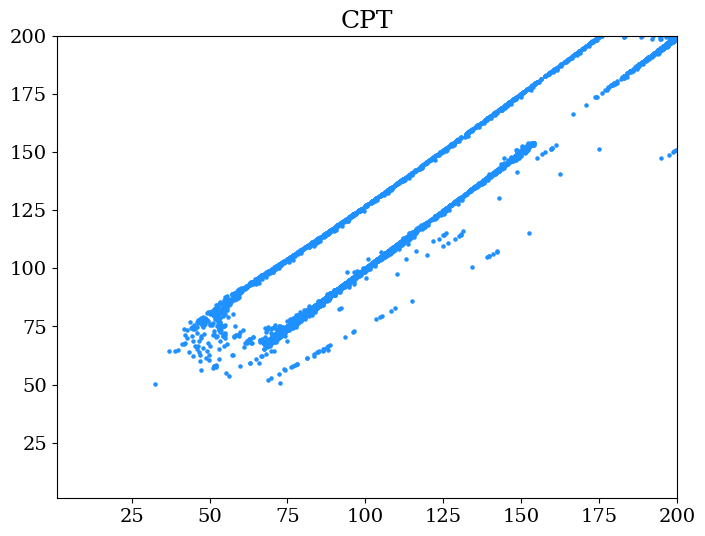

{'N': 200, 'alpha': np.float64(0.6368612839054785), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.971088209611549), 'A': np.float64(0.9259773695112138), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.7557021408552176)}


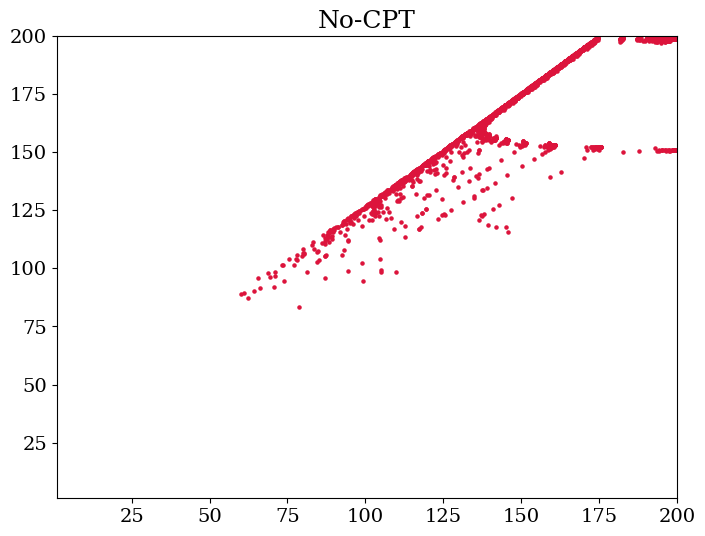

{'N': 200, 'alpha': np.float64(0.49471071412035594), 'gamma': np.float64(0.7444670747687563), 'lambda': np.float64(1.9442657928247997), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.8426771556929005), 'A': np.float64(0.5213882682508424), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.9157117092949846)}


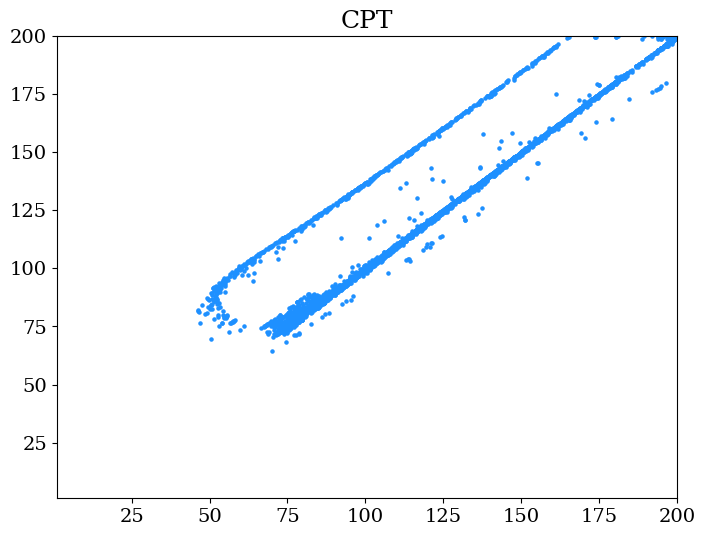

{'N': 200, 'alpha': np.float64(0.49471071412035594), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.8426771556929005), 'A': np.float64(0.5213882682508424), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.9157117092949846)}


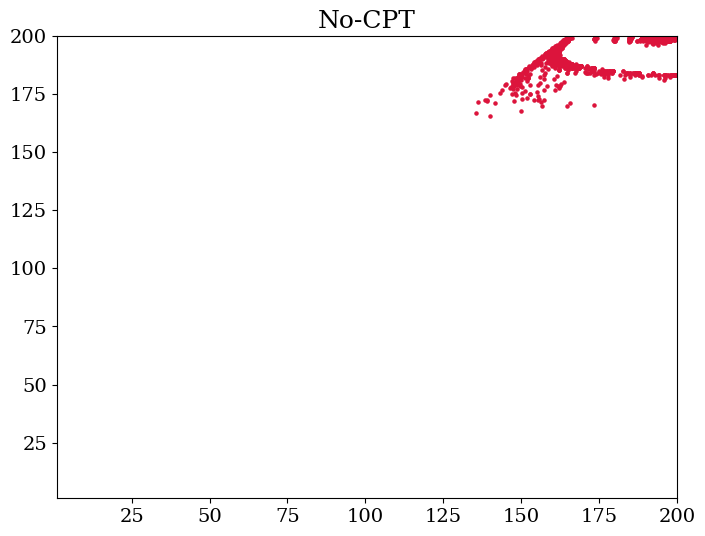

{'N': 200, 'alpha': np.float64(0.5956936604085595), 'gamma': np.float64(0.7572437401656436), 'lambda': np.float64(2.418298376775602), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.069816958015775), 'A': np.float64(0.7160821365782625), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.9384820478933613)}


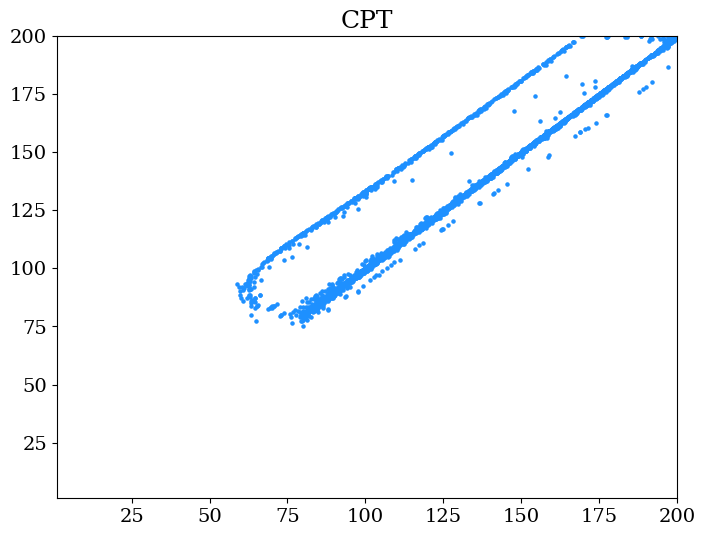

{'N': 200, 'alpha': np.float64(0.5956936604085595), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.069816958015775), 'A': np.float64(0.7160821365782625), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.9384820478933613)}


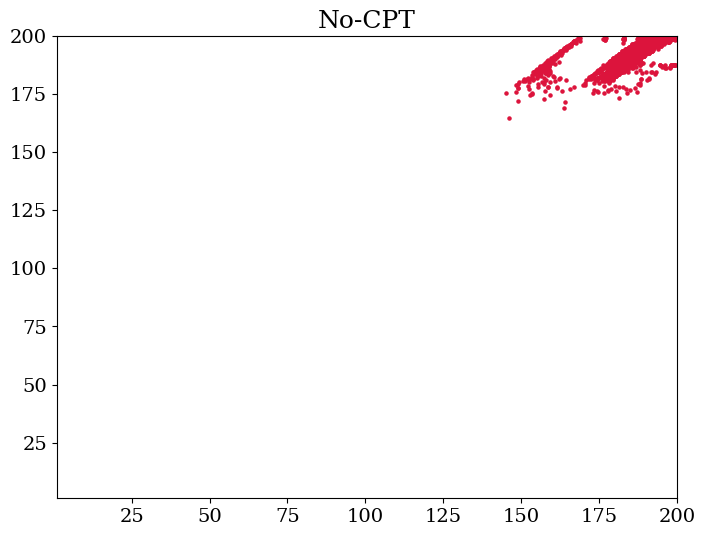

{'N': 200, 'alpha': np.float64(0.3283377045396712), 'gamma': np.float64(0.7079729908233682), 'lambda': np.float64(2.8204553123631757), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.882201449890495), 'A': np.float64(0.3021925170893475), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.7353031246581752)}


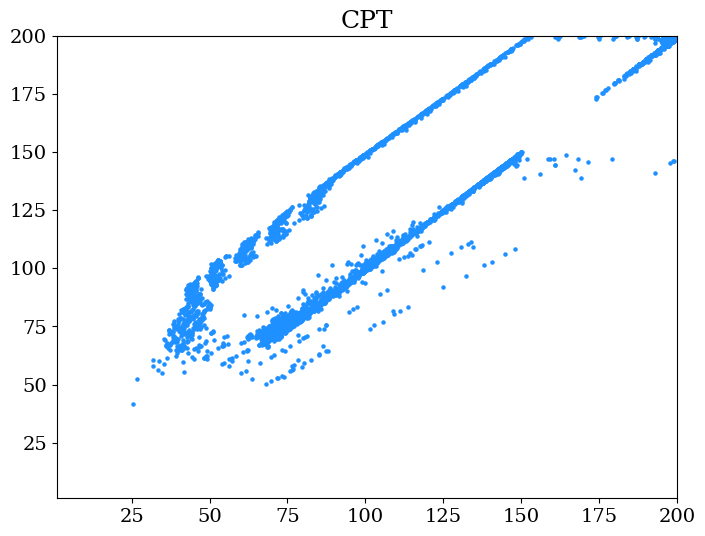

{'N': 200, 'alpha': np.float64(0.3283377045396712), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.882201449890495), 'A': np.float64(0.3021925170893475), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.7353031246581752)}


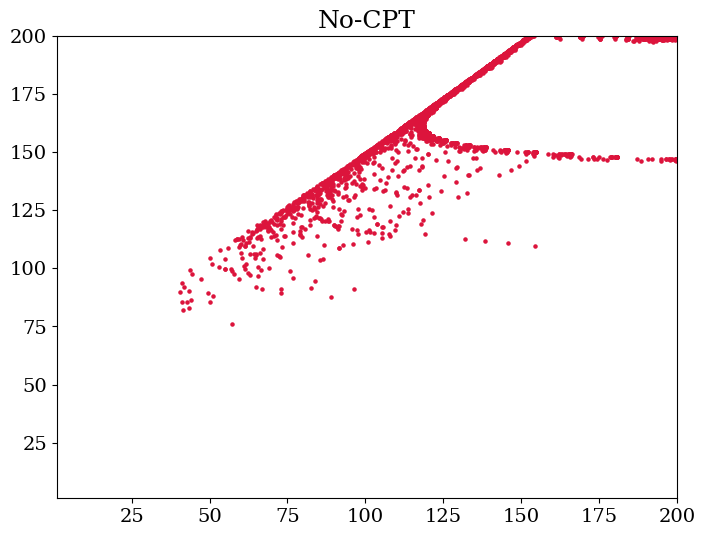

{'N': 200, 'alpha': np.float64(0.5971415485803266), 'gamma': np.float64(0.7610122729317148), 'lambda': np.float64(2.4359914529734867), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.479115317752315), 'A': np.float64(0.7785965520185197), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.939014017258521)}


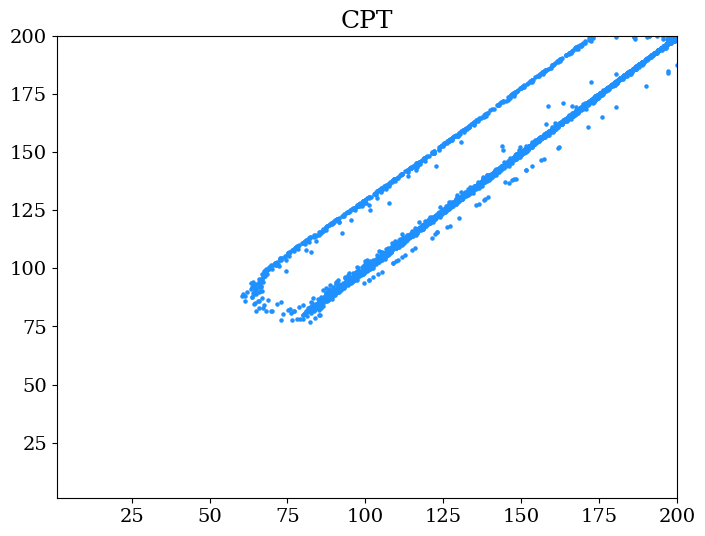

{'N': 200, 'alpha': np.float64(0.5971415485803266), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.479115317752315), 'A': np.float64(0.7785965520185197), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.939014017258521)}


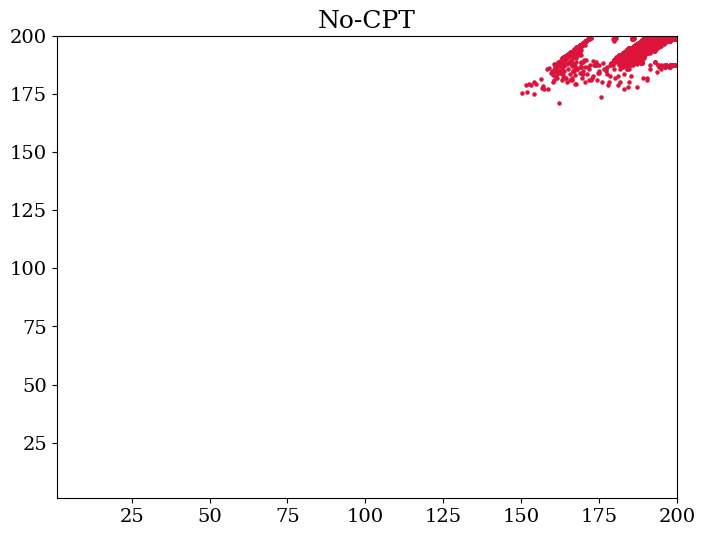

{'N': 200, 'alpha': np.float64(0.5007336058733556), 'gamma': np.float64(0.6289494973677938), 'lambda': np.float64(2.8685240163355403), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.227266371647508), 'A': np.float64(0.6111587358650415), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.7817392547231877)}


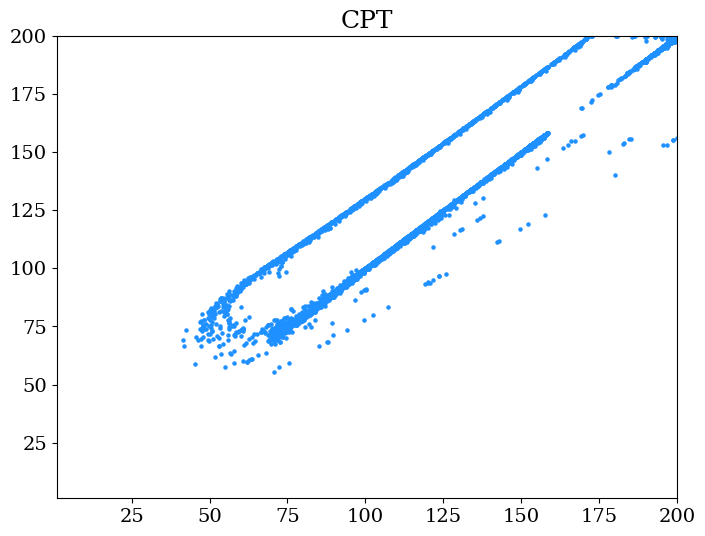

{'N': 200, 'alpha': np.float64(0.5007336058733556), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(4.227266371647508), 'A': np.float64(0.6111587358650415), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.7817392547231877)}


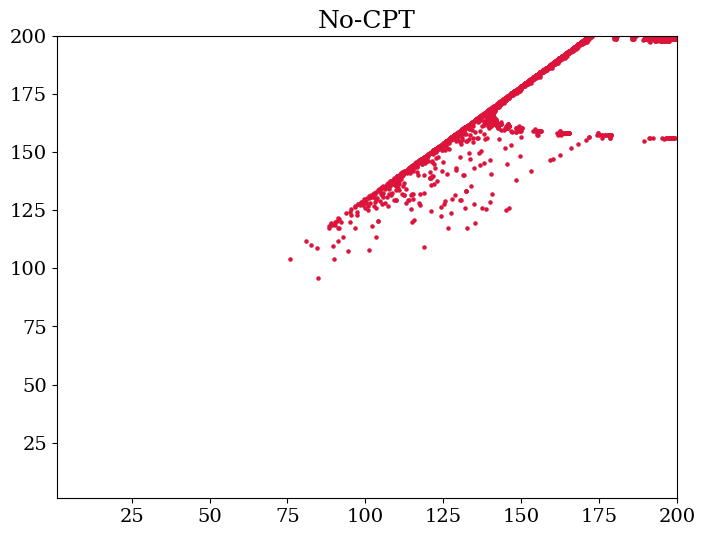

{'N': 200, 'alpha': np.float64(0.6299238252968591), 'gamma': np.float64(0.6711867436723997), 'lambda': np.float64(2.8723397839506326), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(3.769681446759605), 'A': np.float64(0.7925189476702738), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.8270899779317678)}


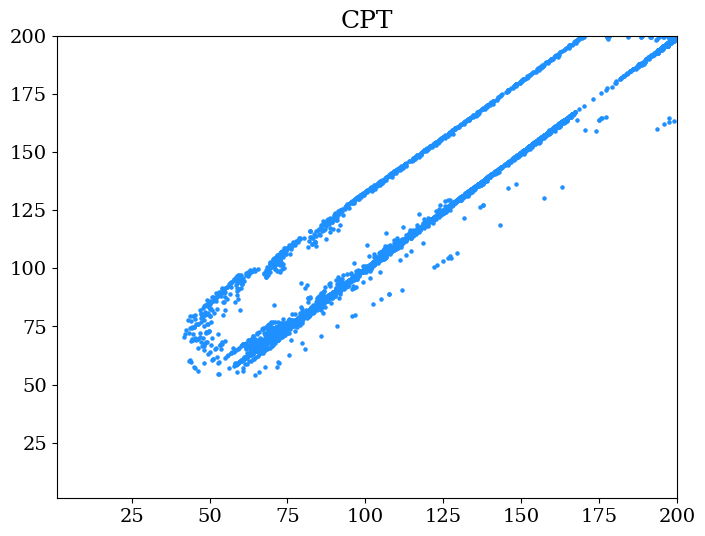

{'N': 200, 'alpha': np.float64(0.6299238252968591), 'gamma': np.float64(1.0), 'lambda': np.float64(1.0), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(3.769681446759605), 'A': np.float64(0.7925189476702738), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.8270899779317678)}


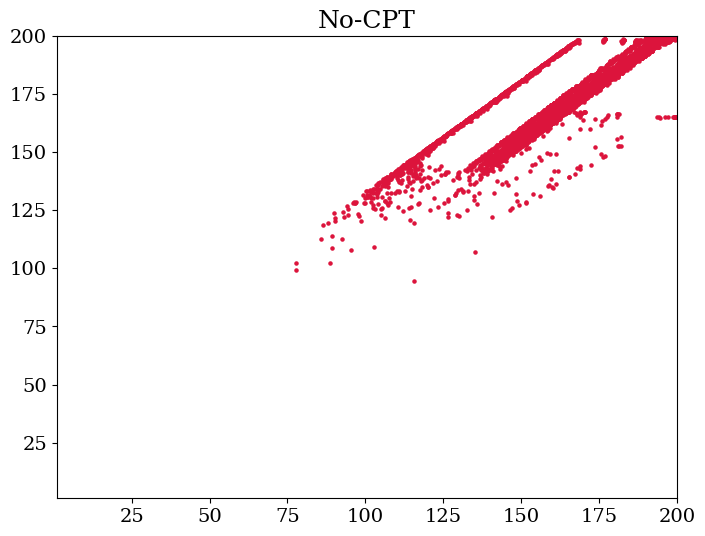

In [137]:
colors = ["dodgerblue"]
directory = "cpt"

with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)
sims = [int(np.mean(f["amplitudes"]) > 28) for f in freqs]


data = []
for idx, f_name in enumerate(tqdm(os.listdir("../"+directory))):
    if sims[idx]:
        with open(os.path.join("../"+directory, f_name), "rb") as f:
            res = pickle.load(f)
        print(res["params"])
        w = unpack_and_dequantize(res["wealth"][:,-1], 200)
        h = unpack_and_dequantize(res["health"][:,-1], 200)
        plt.scatter(w,h,s=5, c="dodgerblue")
        plt.xlim(1,200)
        plt.ylim(1,200)
        plt.title("CPT")
        plt.show()

        P = res["params"]
        nocpt_f = f"{P["alpha"]}_1.0_1.0_{P["rate"]}_{P["A"]}_{P["shock_size"]}.pickle"
        with open(os.path.join("../nocpt", nocpt_f), "rb") as f:
            res = pickle.load(f)
        print(res["params"])
        w = unpack_and_dequantize(res["wealth"][:,-1], 200)
        h = unpack_and_dequantize(res["health"][:,-1], 200)
        plt.scatter(w,h,s=5, c="crimson")
        plt.xlim(1,200)
        plt.ylim(1,200)
        plt.title("No-CPT")
        plt.show()